# Math Bot

## Exploratory Data Analysis

In [2]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import json
from dotenv import load_dotenv
from openai import OpenAI
import re

In [3]:
## Setting up env and openAI api key
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
openai = OpenAI()

In [16]:
# Load the dataset
df = pd.read_csv("./data/hendrycks_math_train.csv")
df.head(3)

,problem,solution,answer,subject,level,unique_id
0,How many vertical asymptotes does the graph of...,The denominator of the rational function facto...,2,Algebra,3,test/algebra/1.json
1,"If $5x - 3 = 12$, what is the value of $5x + 3$?",Adding 6 to both sides of $5x - 3 =12$ gives $...,18,Prealgebra,2,test/prealgebra/2002.json
2,Ryan has 3 red lava lamps and 3 blue lava lamp...,There are $\binom{6}{3}=20$ ways for Ryan to a...,\dfrac{7}{20},Counting & Probability,5,test/counting_and_probability/967.json


In [4]:
print(f"Number of Appliances: {len(df)}")

Number of Appliances: 12000


In [5]:
# Investigate a particular datapoint
datapoint = df.iloc[1]
print(datapoint)

problem       If $5x - 3 = 12$, what is the value of $5x + 3$?
solution     Adding 6 to both sides of $5x - 3 =12$ gives $...
answer                                                      18
subject                                             Prealgebra
level                                                        2
unique_id                            test/prealgebra/2002.json
Name: 1, dtype: object


In [6]:
# Investigate
print(datapoint['problem'])
print(datapoint['solution'])
print(datapoint['answer'])
print(datapoint['subject'])
print(datapoint['level'])
print(datapoint['unique_id'])

If $5x - 3 = 12$, what is the value of $5x + 3$?
Adding 6 to both sides of $5x - 3 =12$ gives $5x -3 + 6 = 12 + 6$.  Simplifying both sides gives $5x + 3 = \boxed{18}$.
18
Prealgebra
2
test/prealgebra/2002.json


In [7]:
# How many have level?
levels = (df['level'] > 0).sum()

print(f"There are {levels:,} with levels which is {levels/len(df)*100:,.1f}%")

There are 12,000 with levels which is 100.0%


In [8]:
# get the levels and the length
levels = []
lengths = []
for index, row in df.iterrows():
    contents = str(row['problem']) + str(row['solution']) + str(row['answer'])
    level = int(row['level'])
    levels.append(level)
    lengths.append(len(contents))

In [9]:
%matplotlib inline

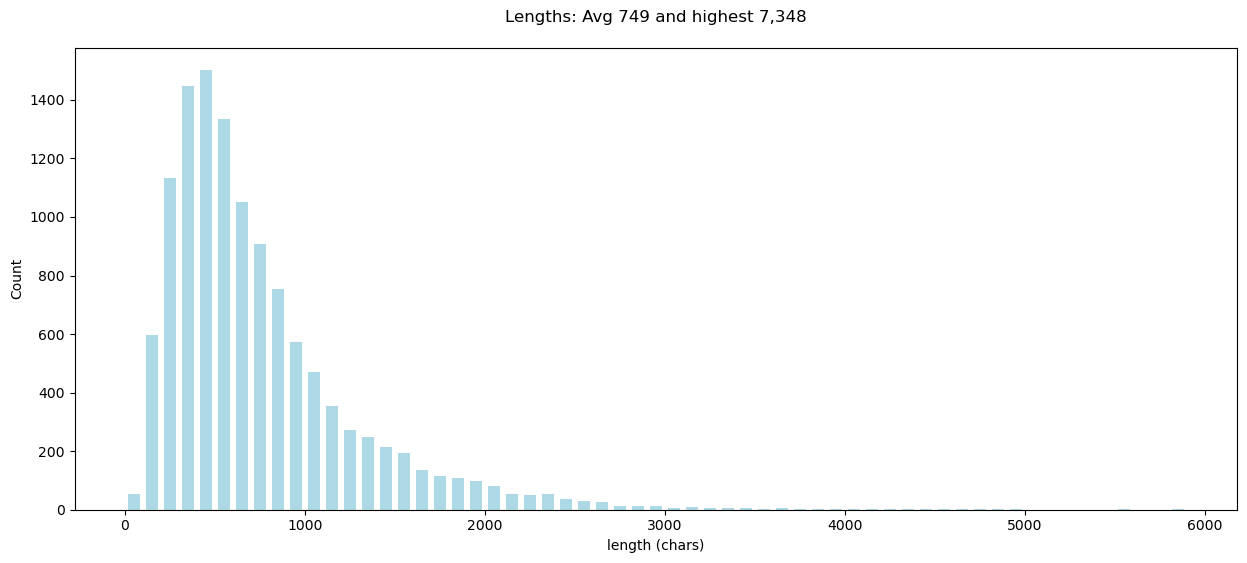

In [10]:
# Plot the distribution of lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel("length (chars)")
plt.ylabel("Count") 
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0,6000,100))
plt.show()

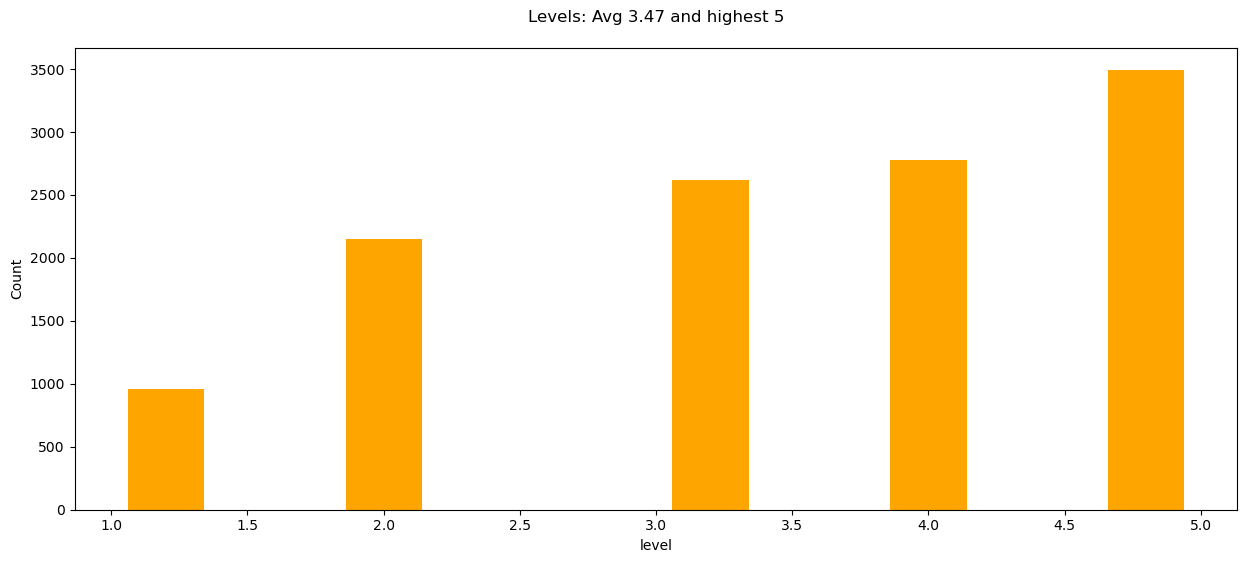

In [11]:
# Plot the distribution of levels
plt.figure(figsize=(15, 6))
plt.title(f"Levels: Avg {sum(levels)/len(levels):,.2f} and highest {max(levels):,}\n")
plt.xlabel("level")
plt.ylabel("Count")
plt.hist(levels, rwidth=0.7, color='orange')
plt.show()

In [12]:
# Plot subject vs level
# Average level of each subject
df['avg_level'] = df.groupby('subject')['level'].transform('mean')

df.head(5)

,problem,solution,answer,subject,level,unique_id,avg_level
0,How many vertical asymptotes does the graph of...,The denominator of the rational function facto...,2,Algebra,3,test/algebra/1.json,3.343783
1,"If $5x - 3 = 12$, what is the value of $5x + 3$?",Adding 6 to both sides of $5x - 3 =12$ gives $...,18,Prealgebra,2,test/prealgebra/2002.json,3.187061
2,Ryan has 3 red lava lamps and 3 blue lava lamp...,There are $\binom{6}{3}=20$ ways for Ryan to a...,\dfrac{7}{20},Counting & Probability,5,test/counting_and_probability/967.json,3.539354
3,Alice wants to buy $3$ pounds of veal at the g...,"Since Alice wants to buy $3$ pounds of veal, w...",1.36,Prealgebra,4,test/prealgebra/2017.json,3.187061
4,"On the $xy$-plane, the origin is labeled with ...","From the M, we can proceed to four different A...",28,Counting & Probability,5,test/counting_and_probability/990.json,3.539354


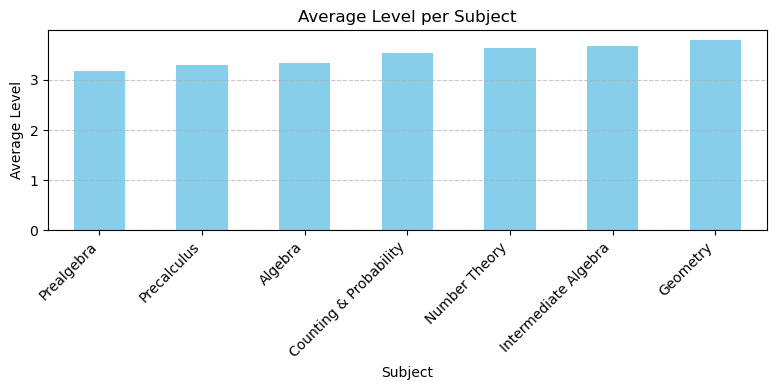

In [13]:
subject_avg = df.groupby('subject')['level'].mean().sort_values()

# Plot
subject_avg.plot(kind='bar', color='skyblue', figsize=(8, 4))
plt.title('Average Level per Subject')
plt.xlabel('Subject')
plt.ylabel('Average Level')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset Curation

In [14]:
df.head(1)

,problem,solution,answer,subject,level,unique_id,avg_level
0,How many vertical asymptotes does the graph of...,The denominator of the rational function facto...,2,Algebra,3,test/algebra/1.json,3.343783


In [20]:
# Creating prompt column
def clean_text(text):
    if pd.isna(text):
        return ''
    # Remove newlines, backslashes, and extra whitespace
    return (str(text)
            .replace('\n', ' ')
            .replace('\\', '')
            .strip())

# Create single-line prompts without \n characters
df['prompt'] = df.apply(
    lambda row: (
        "Assess difficulty (1-5) "
        f"Problem: {clean_text(row['problem'])}; "
        f"Answer: {clean_text(row['answer'])}; "
        f"Subject: {clean_text(row['subject'])}; "
        f"Level: {row['level']}"
    ),
    axis=1
)

df['test_prompt'] = df.apply(
    lambda row: (
        "Assess difficulty (1-5): " +
        f"Problem: {clean_text(row['problem'])} | " +
        f"Answer: {clean_text(row['answer'])} | " +
        f"Subject: {clean_text(row['subject'])}"
    ),
    axis=1
)

In [16]:
# Investigate the prompt that will be used during training:
df.loc[1].prompt

'Assess difficulty (1-5) Problem: If $5x - 3 = 12$, what is the value of $5x + 3$?; Answer: 18; Subject: Prealgebra; Level: 2'

In [10]:
# Evaluating the model
# ANSI color codes for terminal output
COLOR_MAP = {
    "green": "\033[92m",
    "orange": "\033[93m",
    "red": "\033[91m"
}
RESET = "\033[0m"

class LevelTester:
    def __init__(self, predictor, title=None, data=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = min(size, len(data)) if data is not None else size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.squared_errors = []
        self.colors = []
    
    def color_for(self, error):
        if error == 0:
            return "green"
        elif error == 1:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        row = self.data.iloc[i]
        truth = row['level']
        raw_guess = self.predictor(row)
        
        # Round and clip predictions to valid levels
        guess = int(round(raw_guess))
        if guess < 1: 
            guess = 1
        elif guess > 5: 
            guess = 5
            
        error = abs(guess - truth)
        sq_error = (guess - truth) ** 2
        color = self.color_for(error)
        
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.squared_errors.append(sq_error)
        self.colors.append(color)
        
        # Shorten problem text for display
        problem_text = row['problem']
        if len(problem_text) > 40:
            problem_text = problem_text[:37] + "..."
        
        print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess} Truth: {truth} "
              f"Error: {error} Item: {problem_text}{RESET}")
    
    def chart(self, title):
        # Add small jitter for better visualization of discrete points
        jitter = 0.05
        x_jitter = [x + random.uniform(-jitter, jitter) for x in self.truths]
        y_jitter = [y + random.uniform(-jitter, jitter) for y in self.guesses]
        
        plt.figure(figsize=(10, 8))
        plt.plot([1, 5], [1, 5], color='deepskyblue', lw=2, alpha=0.6)  # Perfect prediction line
        plt.scatter(x_jitter, y_jitter, s=40, c=self.colors, alpha=0.7)
        
        # Configure plot appearance
        plt.xticks([1, 2, 3, 4, 5])
        plt.yticks([1, 2, 3, 4, 5])
        plt.xlim(0.5, 5.5)
        plt.ylim(0.5, 5.5)
        plt.xlabel('Ground Truth Level')
        plt.ylabel('Predicted Level')
        plt.title(title)
        plt.grid(alpha=0.2)
        plt.show()
    
    def report(self):
        mae = sum(self.errors) / self.size
        rmse = math.sqrt(sum(self.squared_errors) / self.size)
        accuracy = sum(1 for e in self.errors if e == 0) / self.size
        near_accuracy = sum(1 for e in self.errors if e <= 1) / self.size
        
        title = (f"{self.title} - MAE: {mae:.2f}, RMSE: {rmse:.2f}\n"
                 f"Exact Accuracy: {accuracy*100:.1f}%, "
                 f"Near Accuracy: {near_accuracy*100:.1f}%")
        self.chart(title)
    
    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()
    
    @classmethod
    def test(cls, predictor, data, title=None, size=250):
        tester = cls(predictor, title, data, size)
        tester.run()

In [18]:
# sample predictor function
def random_level_predictor(row):
    return random.uniform(1,5)

1: Guess: 4 Truth: 3 Error: 1 Item: How many vertical asymptotes does the...
2: Guess: 1 Truth: 2 Error: 1 Item: If $5x - 3 = 12$, what is the value o...
3: Guess: 2 Truth: 5 Error: 3 Item: Ryan has 3 red lava lamps and 3 blue ...
4: Guess: 2 Truth: 4 Error: 2 Item: Alice wants to buy $3$ pounds of veal...
5: Guess: 4 Truth: 5 Error: 1 Item: On the $xy$-plane, the origin is labe...
6: Guess: 4 Truth: 5 Error: 1 Item: One sphere is centered at $(3,-5,7)$ ...
7: Guess: 5 Truth: 4 Error: 1 Item: In triangle $\triangle ABC,$ we have ...
8: Guess: 1 Truth: 5 Error: 4 Item: $AB = 20$ cm, $m \angle A = 30^\circ$...
9: Guess: 3 Truth: 5 Error: 2 Item: We have two geometric sequences of po...
10: Guess: 1 Truth: 2 Error: 1 Item: Connie is starting an exercise progra...
11: Guess: 2 Truth: 4 Error: 2 Item: The sum of the squares of three conse...
12: Guess: 3 Truth: 4 Error: 1 Item: Carpet costs $\$21.95$ per square yar...
13: Guess: 1 Truth: 5 Error: 4 Item: One morning each member of Angela's 

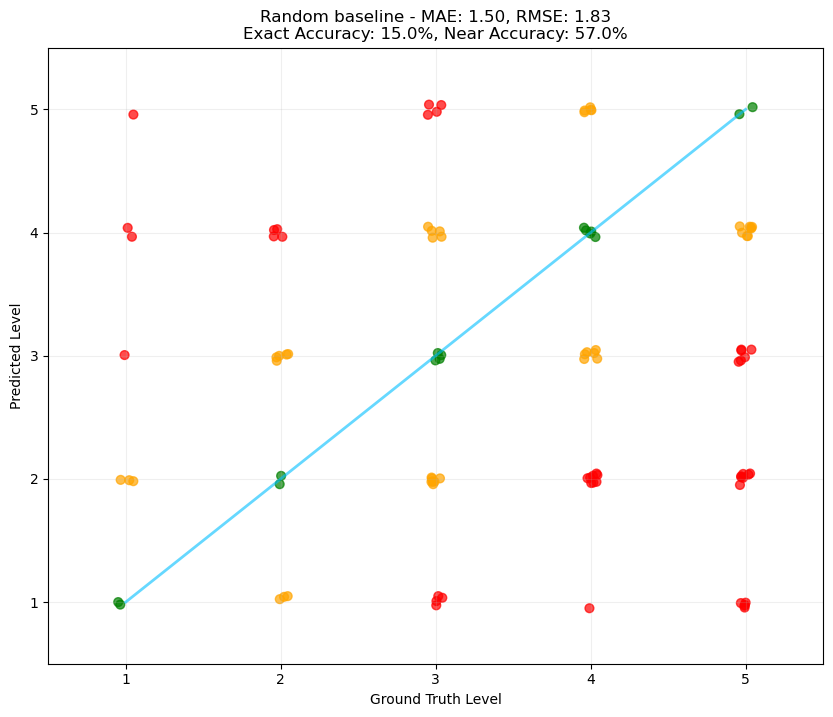

In [19]:
# Set the random seed
random.seed(42)

LevelTester.test(
    predictor=random_level_predictor,
    data=df,
    title="Random baseline",
    size=100
)

## Using GPT-4o-mini for Prompt Egineering

In [48]:
df.loc[0].test_prompt

'Assess difficulty (1-5): Problem: How many vertical asymptotes does the graph of $y=frac{2}{x^2+x-6}$ have? | Answer: 2 | Subject: Algebra'

In [74]:
def messages_for(item):
    system_message = "You estimate the difficulty level (1-5) of a math problem based in the problem statement, answer and subject. Reply ONLY with a single integer between 1 and 5, no explanations."
    user_prompt = item.test_prompt
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Level is: "}
    ]

In [73]:
messages_for(df.loc[0])

[{'role': 'system',
  'content': 'You estimate the difficulty level (1-5) of a math problem based in the problem statement, answer and subject. Reply ONLY with a single integer between 1 and 5, no explanations.'},
 {'role': 'user',
  'content': 'Assess difficulty (1-5): Problem: How many vertical asymptotes does the graph of $y=frac{2}{x^2+x-6}$ have? | Answer: 2 | Subject: Algebra'},
 {'role': 'assistant', 'content': 'Level is: '}]

In [75]:
import re

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    
    # Extract first integer from reply
    match = re.search(r'\d+', reply)
    return int(match.group()) if match else 3  # Default to 3 if no number found

1: Guess: 2 Truth: 3 Error: 1 Item: How many vertical asymptotes does the...
2: Guess: 2 Truth: 2 Error: 0 Item: If $5x - 3 = 12$, what is the value o...
3: Guess: 3 Truth: 5 Error: 2 Item: Ryan has 3 red lava lamps and 3 blue ...
4: Guess: 2 Truth: 4 Error: 2 Item: Alice wants to buy $3$ pounds of veal...
5: Guess: 4 Truth: 5 Error: 1 Item: On the $xy$-plane, the origin is labe...
6: Guess: 4 Truth: 5 Error: 1 Item: One sphere is centered at $(3,-5,7)$ ...
7: Guess: 4 Truth: 4 Error: 0 Item: In triangle $\triangle ABC,$ we have ...
8: Guess: 4 Truth: 5 Error: 1 Item: $AB = 20$ cm, $m \angle A = 30^\circ$...
9: Guess: 4 Truth: 5 Error: 1 Item: We have two geometric sequences of po...
10: Guess: 3 Truth: 2 Error: 1 Item: Connie is starting an exercise progra...
11: Guess: 4 Truth: 4 Error: 0 Item: The sum of the squares of three conse...
12: Guess: 4 Truth: 4 Error: 0 Item: Carpet costs $\$21.95$ per square yar...
13: Guess: 4 Truth: 5 Error: 1 Item: One morning each member of Angela's 

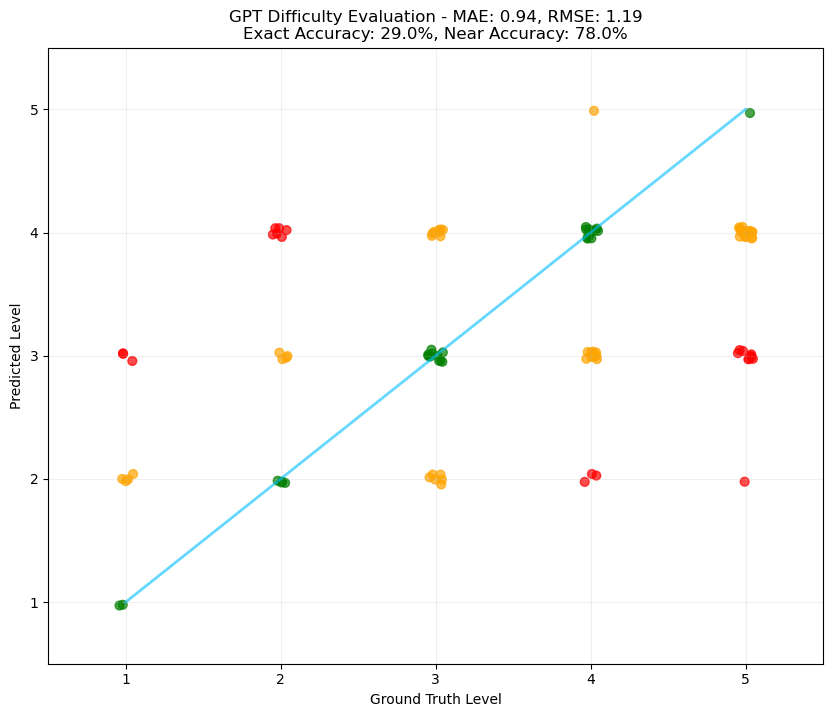

In [76]:
# Test with LevelTester
LevelTester.test(
    predictor=gpt_4o_mini,
    data=df,
    title="GPT Difficulty Evaluation",
    size=100
)

## Fine Tuning

In [15]:
df_test = pd.read_csv("./data/hendrycks_math_test.csv")
df_test

,problem,solution,answer,subject,level,unique_id
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",$f(-2)+f(-1)+f(0)=\frac{3(-2)-2}{-2-2}+\frac{3...,\frac{14}{3},Algebra,3,test/algebra/2584.json
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json
4,The results of a cross-country team's training...,Evelyn covered more distance in less time than...,\text{Evelyn},Algebra,2,test/algebra/1349.json
...,...,...,...,...,...,...
495,What is the domain of the function $f(x) = \fr...,The inner logarithm is only defined if $x - 2 ...,"(2,12) \cup (12,102)",Intermediate Algebra,4,test/intermediate_algebra/1981.json
496,Let $z = 1+i$ and $w = \dfrac{3z+1}{5z+7}$. Fi...,"Plugging in, we have $w = \dfrac{3(1+i)+1}{5(1...",\frac{5}{13},Intermediate Algebra,3,test/intermediate_algebra/1232.json
497,An equiangular octagon has four sides of lengt...,The octagon can be partitioned into five squar...,\frac{7}{2},Geometry,5,test/geometry/561.json
498,A sequence $(a_n)$ is defined as follows:\n\[a...,"First, if $a_3 = a_1,$ then\n\[a_1 = a_3 = a_5...",-1,Intermediate Algebra,5,test/intermediate_algebra/1508.json


In [17]:
df_train = df
len(df_train)

12000

In [18]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 500 examples (and 1 epoch)

fine_tune_train = df_train.iloc[:500]
fine_tune_validation = df_train.iloc[500:550]

In [21]:
# Create prompt and test_prompt fpr test dataset
# Create single-line prompts without \n characters
df_test['prompt'] = df.apply(
    lambda row: (
        "Assess difficulty (1-5) "
        f"Problem: {clean_text(row['problem'])}; "
        f"Answer: {clean_text(row['answer'])}; "
        f"Subject: {clean_text(row['subject'])}; "
        f"Level: {row['level']}"
    ),
    axis=1
)

df_test['test_prompt'] = df.apply(
    lambda row: (
        "Assess difficulty (1-5): " +
        f"Problem: {clean_text(row['problem'])} | " +
        f"Answer: {clean_text(row['answer'])} | " +
        f"Subject: {clean_text(row['subject'])}"
    ),
    axis=1
)

In [23]:
df_test

,problem,solution,answer,subject,level,unique_id,prompt,test_prompt
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,Assess difficulty (1-5) Problem: How many vert...,Assess difficulty (1-5): Problem: How many ver...
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json,Assess difficulty (1-5) Problem: If $5x - 3 = ...,Assess difficulty (1-5): Problem: If $5x - 3 =...
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",$f(-2)+f(-1)+f(0)=\frac{3(-2)-2}{-2-2}+\frac{3...,\frac{14}{3},Algebra,3,test/algebra/2584.json,Assess difficulty (1-5) Problem: Ryan has 3 re...,Assess difficulty (1-5): Problem: Ryan has 3 r...
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,Assess difficulty (1-5) Problem: Alice wants t...,Assess difficulty (1-5): Problem: Alice wants ...
4,The results of a cross-country team's training...,Evelyn covered more distance in less time than...,\text{Evelyn},Algebra,2,test/algebra/1349.json,Assess difficulty (1-5) Problem: On the $xy$-p...,Assess difficulty (1-5): Problem: On the $xy$-...
...,...,...,...,...,...,...,...,...
495,What is the domain of the function $f(x) = \fr...,The inner logarithm is only defined if $x - 2 ...,"(2,12) \cup (12,102)",Intermediate Algebra,4,test/intermediate_algebra/1981.json,Assess difficulty (1-5) Problem: Evaluate: $[1...,Assess difficulty (1-5): Problem: Evaluate: $[...
496,Let $z = 1+i$ and $w = \dfrac{3z+1}{5z+7}$. Fi...,"Plugging in, we have $w = \dfrac{3(1+i)+1}{5(1...",\frac{5}{13},Intermediate Algebra,3,test/intermediate_algebra/1232.json,Assess difficulty (1-5) Problem: A star-polygo...,Assess difficulty (1-5): Problem: A star-polyg...
497,An equiangular octagon has four sides of lengt...,The octagon can be partitioned into five squar...,\frac{7}{2},Geometry,5,test/geometry/561.json,Assess difficulty (1-5) Problem: If $frac{sqrt...,Assess difficulty (1-5): Problem: If $frac{sqr...
498,A sequence $(a_n)$ is defined as follows:\n\[a...,"First, if $a_3 = a_1,$ then\n\[a_1 = a_3 = a_5...",-1,Intermediate Algebra,5,test/intermediate_algebra/1508.json,Assess difficulty (1-5) Problem: A referendum ...,Assess difficulty (1-5): Problem: A referendum...


In [22]:
type(fine_tune_train)

pandas.core.frame.DataFrame

In [30]:
# exploring prompt and test_prompt columns
print(df_test.iloc[0].prompt)

print(df_test.iloc[0].test_prompt)

Assess difficulty (1-5) Problem: How many vertical asymptotes does the graph of $y=frac{2}{x^2+x-6}$ have?; Answer: 2; Subject: Algebra; Level: 3
Assess difficulty (1-5): Problem: How many vertical asymptotes does the graph of $y=frac{2}{x^2+x-6}$ have? | Answer: 2 | Subject: Algebra


### Preparing our data for Fine-Tuning in JSONL (JSON Lines) format and upload to OpenAI

#### Step 1

In [31]:
def messages_for(item):
    system_message = "You estimate the difficulty level (1-5) of a math problem based in the problem statement, answer and subject. Reply ONLY with a single integer between 1 and 5, no explanations."
    user_prompt = item['test_prompt']
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Level is: "}
    ]

In [40]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form

def make_jsonl(items):
    result = ""
    for _, row in items.iterrows():
        messages = messages_for(row)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str + '}\n'
    return result.strip()

In [41]:
# Convert the items into json and write them to a file
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [43]:
write_jsonl(fine_tune_train, "fine_tune_train__math.jsonl")

In [46]:
write_jsonl(fine_tune_validation, "fine_tune__validation_math.jsonl")

In [48]:
with open("fine_tune_train__math.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [49]:
train_file

FileObject(id='file-3pzJTyAqKhxPats4s1NPKW', bytes=292834, created_at=1754111614, filename='fine_tune_train__math.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [50]:
with open("fine_tune__validation_math.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [51]:
validation_file

FileObject(id='file-CcCwsmonFvMB3bspLrppMS', bytes=29184, created_at=1754111650, filename='fine_tune__validation_math.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

#### Step 2

In [60]:
# Weights and biases integration
wandb_integration = {"type": "wandb", "wandb": {"project": "math_level"}}

In [61]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="level"
)

FineTuningJob(id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq', created_at=1754112528, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-yxWr7lx8zJaFRRzprM74UkQJ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-3pzJTyAqKhxPats4s1NPKW', validation_file='file-CcCwsmonFvMB3bspLrppMS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='math_level', entity=None, name=None, tags=None, run_id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='level', usage_metri

In [62]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq', created_at=1754112528, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-yxWr7lx8zJaFRRzprM74UkQJ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-3pzJTyAqKhxPats4s1NPKW', validation_file='file-CcCwsmonFvMB3bspLrppMS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='math_level', entity=None, name=None, tags=None, run_id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix=

In [63]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [65]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq', created_at=1754112528, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-yxWr7lx8zJaFRRzprM74UkQJ', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-3pzJTyAqKhxPats4s1NPKW', validation_file='file-CcCwsmonFvMB3bspLrppMS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='math_level', entity=None, name=None, tags=None, run_id='ftjob-JNz2Tl9tE7WVkd4Wt6hfcMDq'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='level', usage_metrics=None, shared_

In [4]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id='xxx', limit=10).data

[FineTuningJobEvent(id='ftevent-fZ2TEi6f7JKZbSgr9ucCYS4l', created_at=1754119538, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-bBcrb283R7a6Eyui2t3UB85r', created_at=1754119532, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-sgQ69J0dgwCIlmC5F3Nc95vR', created_at=1754119532, level='info', message='Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:test:level:C00PSNPd passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 'blocking'}, {'

#### Step 3: Test our fine tuned model

In [5]:
fine_tuned_model = openai.fine_tuning.jobs.retrieve('xxx').fine_tuned_model

In [6]:
# The prompt
def messages_for(item):
    system_message = "You estimate the difficulty level (1-5) of a math problem based in the problem statement, answer and subject. Reply ONLY with a single integer between 1 and 5, no explanations."
    user_prompt = item['test_prompt']
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Level is: "}
    ]

In [7]:
# The function for gpt-4o-mini
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model,
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    
    # Extract first integer from reply
    match = re.search(r'\d+', reply)
    return int(match.group()) if match else 3  # Default to 3 if no number found

1: Guess: 3 Truth: 2 Error: 1 Item: Convert the point $(0,3)$ in rectangu...
2: Guess: 3 Truth: 5 Error: 2 Item: Define
\[p = \sum_{k = 1}^\infty \fra...
3: Guess: 3 Truth: 3 Error: 0 Item: If $f(x) = \frac{3x-2}{x-2}$, what is...
4: Guess: 3 Truth: 3 Error: 0 Item: How many positive whole-number diviso...
5: Guess: 3 Truth: 2 Error: 1 Item: The results of a cross-country team's...
6: Guess: 3 Truth: 2 Error: 1 Item: A regular hexagon can be divided into...
7: Guess: 3 Truth: 3 Error: 0 Item: What is the smallest positive perfect...
8: Guess: 3 Truth: 4 Error: 1 Item: The set of points $(x,y,z)$ that sati...
9: Guess: 3 Truth: 3 Error: 0 Item: What is the distance, in units, betwe...
10: Guess: 3 Truth: 5 Error: 2 Item: The expression $2\cdot 3 \cdot 4\cdot...
11: Guess: 3 Truth: 3 Error: 0 Item: What is the least positive integer mu...
12: Guess: 3 Truth: 5 Error: 2 Item: Let $p(x)$ be a polynomial of degree ...
13: Guess: 3 Truth: 5 Error: 2 Item: The proper divisors of 12 are 1, 2, 

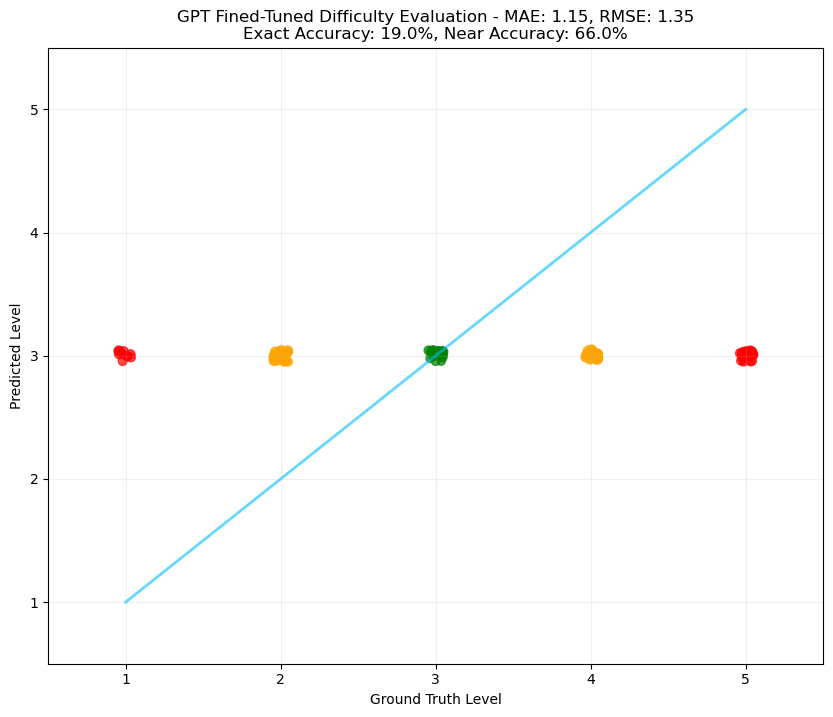

In [26]:
LevelTester.test(
    predictor=gpt_fine_tuned,
    data=df_test,
    title="GPT Fined-Tuned Difficulty Evaluation",
    size=100
)

## Conclusion:

When trying a fine tunning approach, we got the following values:

- MAE (Mean Absolute Error) = 1.15
- RMSE (Root Mean Squared Error) = 1.35
- Exact Accuracy = 19%
- Near Accuracy = 66%

however, when we tried with a prompt engineering appriach, the values were better compared with the fine tunnign approach, the valued obtained were:
- MAE = 0.94
- RMSE = 1.19
- Exact Accuracy = 29%
- Near Accuracy = 78%


This could be due to many reason, such as:

- Data Limitations: The dataset used for fine-tuning might have been insufficient in size, quality, or diversity to effectively teach the model the nuances of the task, leading to poorer generalization. Prompt engineering leverages the model's broader pre-trained knowledge.

- Task Suitability: The specific task might be inherently better suited to being solved through carefully crafted instructions and in-context learning (prompt engineering) rather than adjusting the model's internal weights via fine-tuning.

- Fine-tuning Complexity: Challenges in selecting optimal hyperparameters (learning rate, epochs, batch size), choosing the right layers to fine-tune, or potential overfitting/underfitting during the fine-tuning process could have hampered its performance.

- Resource Efficiency: Prompt engineering requires significantly less computational resources and time compared to fine-tuning, making it a more efficient solution in this case, especially given the better results.

- Preserving General Knowledge: Fine-tuning, especially on a smaller or narrow dataset, risks "catastrophic forgetting" of the model's broad pre-trained knowledge. Prompt engineering preserves this knowledge, which might be crucial for the task.